# Current Bid Analysis - Distribution & Transformations

This notebook analyzes the `current_bid` column from the items_details dataset and explores various transformations to achieve normality.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Data

In [2]:
# Load dataset
data_path = '/workspaces/maxsold/data/raw_data/items_details/items_details_20251201.parquet'
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (229125, 17)

Columns: ['id', 'auction_id', 'title', 'description', 'taxable', 'viewed', 'minimum_bid', 'starting_bid', 'current_bid', 'proxy_bid', 'start_time', 'end_time', 'lot_number', 'bid_count', 'bidding_extended', 'buyer_premium', 'timezone']

First few rows:


,id,auction_id,title,description,taxable,viewed,minimum_bid,starting_bid,current_bid,proxy_bid,start_time,end_time,lot_number,bid_count,bidding_extended,buyer_premium,timezone
0,7490263,103882,Gorgeous AAA Untreated Opal,Big 7.28ct AAA beautiful untreated Ethiopian o...,True,191,25.00,1,22.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,1,5,False,18,America/New_York
1,7490264,103882,Natural High Quality Emerald,"1.50ct natural beautiful, high quality \nEmera...",True,507,56.67,1,51.67,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,2,15,False,18,America/New_York
2,7490265,103882,Natural Ruby,4.74ct natural deep red\nOctagon Ruby \n13x7mm...,True,477,28.00,1,25.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,3,7,False,18,America/New_York
3,7490266,103882,Natural Green Tourmaline,1.84ct natural baguette cut\nGreen tourmaline ...,True,143,4.00,1,3.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,4,3,False,18,America/New_York
4,7490267,103882,Natural Bicolored Tourmaline,3.05ct pear cut 2pcs\nUntreated bicolored tour...,True,291,10.00,1,9.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:16:32-05:00,5,9,True,18,America/New_York


## 2. Basic Statistics for Current Bid

In [3]:
# Extract current_bid column
current_bid = df['current_bid'].copy()

print("="*60)
print("CURRENT BID STATISTICS")
print("="*60)
print(f"\nTotal records: {len(current_bid):,}")
print(f"Missing values: {current_bid.isnull().sum():,} ({100*current_bid.isnull().sum()/len(current_bid):.2f}%)")
print(f"\nDescriptive Statistics:")
print(current_bid.describe())

print(f"\nAdditional Statistics:")
print(f"  Median: ${current_bid.median():.2f}")
print(f"  Mode: ${current_bid.mode().values[0]:.2f}")
print(f"  Std Dev: ${current_bid.std():.2f}")
print(f"  Variance: ${current_bid.var():.2f}")
print(f"  Skewness: {current_bid.skew():.4f}")
print(f"  Kurtosis: {current_bid.kurtosis():.4f}")

print(f"\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = current_bid.quantile(p/100)
    print(f"  {p}th percentile: ${val:.2f}")

CURRENT BID STATISTICS

Total records: 229,125
Missing values: 0 (0.00%)

Descriptive Statistics:
count    229125.000000
mean         26.838278
std         111.316193
min           0.000000
25%           2.000000
50%           7.000000
75%          23.000000
max       14000.000000
Name: current_bid, dtype: float64

Additional Statistics:
  Median: $7.00
  Mode: $1.00
  Std Dev: $111.32
  Variance: $12391.29
  Skewness: 42.2749
  Kurtosis: 3494.8497

Percentiles:
  1th percentile: $0.00
  5th percentile: $0.00
  10th percentile: $1.00
  25th percentile: $2.00
  50th percentile: $7.00
  75th percentile: $23.00
  90th percentile: $55.00
  95th percentile: $96.00
  99th percentile: $310.00


In [4]:
# Check for zero and negative values
print("\nValue Distribution:")
print(f"  Zero values: {(current_bid == 0).sum():,} ({100*(current_bid == 0).sum()/len(current_bid):.2f}%)")
print(f"  Negative values: {(current_bid < 0).sum():,}")
print(f"  <= $10: {(current_bid <= 10).sum():,} ({100*(current_bid <= 10).sum()/len(current_bid):.2f}%)")
print(f"  $10-$50: {((current_bid > 10) & (current_bid <= 50)).sum():,} ({100*((current_bid > 10) & (current_bid <= 50)).sum()/len(current_bid):.2f}%)")
print(f"  $50-$100: {((current_bid > 50) & (current_bid <= 100)).sum():,} ({100*((current_bid > 50) & (current_bid <= 100)).sum()/len(current_bid):.2f}%)")
print(f"  $100-$500: {((current_bid > 100) & (current_bid <= 500)).sum():,} ({100*((current_bid > 100) & (current_bid <= 500)).sum()/len(current_bid):.2f}%)")
print(f"  > $500: {(current_bid > 500).sum():,} ({100*(current_bid > 500).sum()/len(current_bid):.2f}%)")


Value Distribution:
  Zero values: 18,822 (8.21%)
  Negative values: 0
  <= $10: 130,570 (56.99%)
  $10-$50: 73,516 (32.09%)
  $50-$100: 14,198 (6.20%)
  $100-$500: 9,879 (4.31%)
  > $500: 962 (0.42%)


## 3. Original Distribution - Current Bid

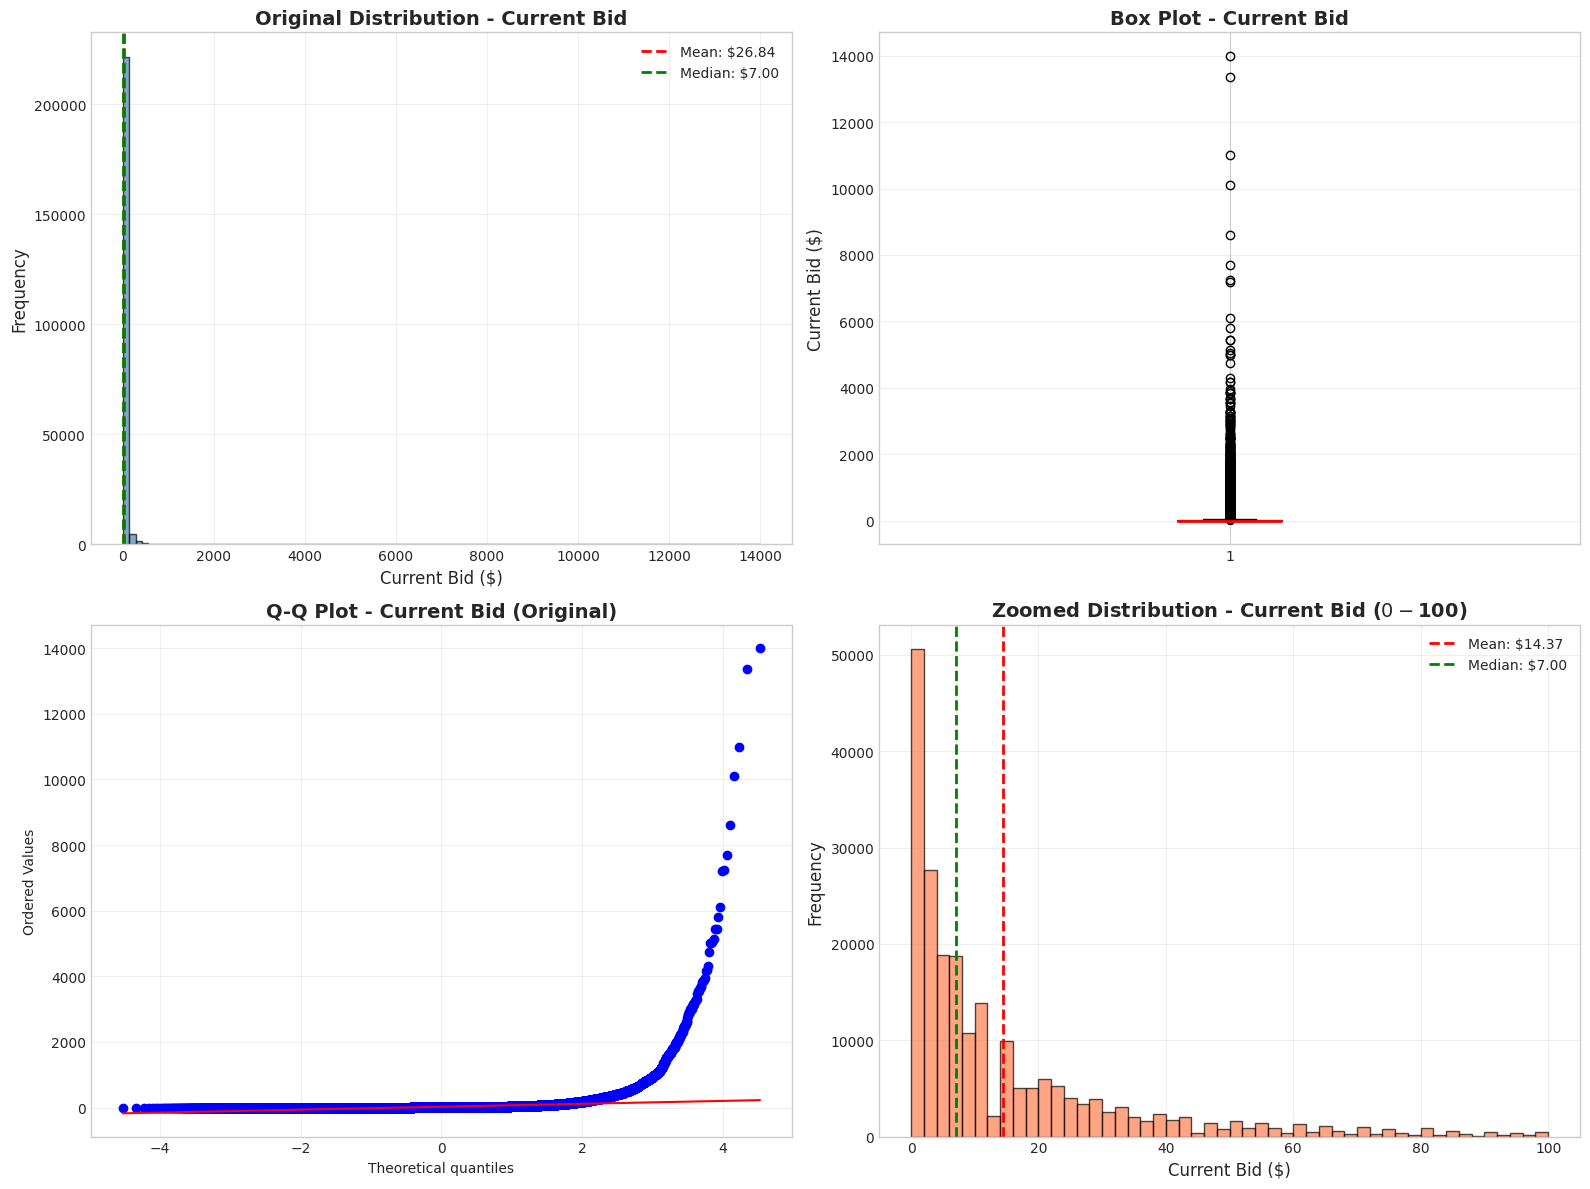

Original distribution plot saved


In [5]:
# Plot original distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram with KDE
axes[0, 0].hist(current_bid.dropna(), bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Current Bid ($)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Original Distribution - Current Bid', fontsize=14, fontweight='bold')
axes[0, 0].axvline(current_bid.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${current_bid.mean():.2f}')
axes[0, 0].axvline(current_bid.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${current_bid.median():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(current_bid.dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_ylabel('Current Bid ($)', fontsize=12)
axes[0, 1].set_title('Box Plot - Current Bid', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q Plot
stats.probplot(current_bid.dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot - Current Bid (Original)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Zoomed histogram (0-100)
current_bid_zoomed = current_bid[current_bid <= 100].dropna()
axes[1, 1].hist(current_bid_zoomed, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].set_xlabel('Current Bid ($)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Zoomed Distribution - Current Bid ($0-$100)', fontsize=14, fontweight='bold')
axes[1, 1].axvline(current_bid_zoomed.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${current_bid_zoomed.mean():.2f}')
axes[1, 1].axvline(current_bid_zoomed.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${current_bid_zoomed.median():.2f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_original_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Original distribution plot saved")

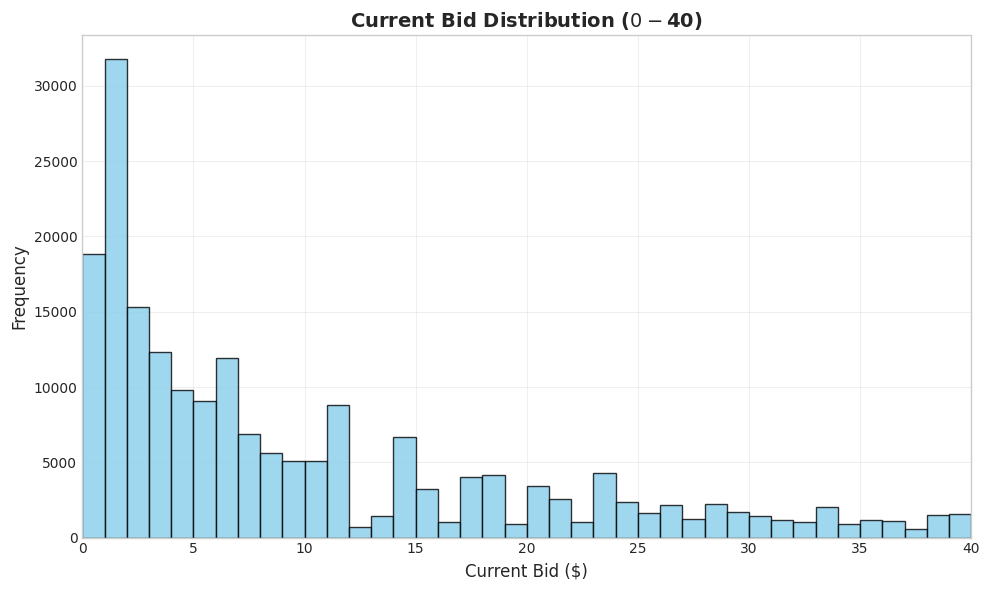

In [6]:
# Histogram of current_bid limited to $0-$40
current_bid_0_40 = current_bid.dropna()
current_bid_0_40 = current_bid_0_40[(current_bid_0_40 >= 0) & (current_bid_0_40 <= 40)]

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(current_bid_0_40, bins=40, edgecolor='black', color='skyblue', alpha=0.8)
ax.set_xlim(0, 40)
ax.set_xlabel('Current Bid ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Current Bid Distribution ($0 - $40)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_0_40_hist.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Frequency counts for current_bid values 0 through 40 (inclusive)
current_bid_range = current_bid[(current_bid >= 0) & (current_bid <= 40)]
counts = pd.Series({i: int((current_bid_range == float(i)).sum()) for i in range(41)})
print("Counts of current_bid == value (0-40):")
print(counts)
print(f"\nTotal records in $0-$40 range: {len(current_bid_range):,}")

Counts of current_bid == value (0-40):
0     18822
1     31766
2     14956
3     11025
4      8270
5      7576
6     10198
7      5804
8      4582
9      4199
10     3944
11     8609
12      564
13      187
14     5861
15     2799
16      470
17     3581
18     3768
19      519
20     3012
21     2173
22      712
23     3870
24     1957
25     1304
26     1861
27     1002
28     1941
29     1472
30     1218
31      935
32      878
33     1860
34      732
35      964
36      910
37      447
38     1317
39      744
40      691
dtype: int64

Total records in $0-$40 range: 197,565


## 4. Transformation 1: Log(x+1) Transform

In [8]:
# Log(x+1) transformation
current_bid_log = np.log1p(current_bid.dropna())

print("="*60)
print("LOG(X+1) TRANSFORMATION")
print("="*60)
print(f"\nDescriptive Statistics:")
print(current_bid_log.describe())
print(f"\nSkewness: {current_bid_log.skew():.4f}")
print(f"Kurtosis: {current_bid_log.kurtosis():.4f}")

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(current_bid_log.sample(min(5000, len(current_bid_log))))
print(f"\nShapiro-Wilk Test (normality):")
print(f"  Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
print(f"  Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (at α=0.05)")

LOG(X+1) TRANSFORMATION

Descriptive Statistics:
count    229125.000000
mean          2.207200
std           1.384613
min           0.000000
25%           1.098612
50%           2.079442
75%           3.178054
max           9.546884
Name: current_bid, dtype: float64

Skewness: 0.4023
Kurtosis: -0.1852

Shapiro-Wilk Test (normality):
  Statistic: 0.970261
  p-value: 0.000000
  Result: Not Normal (at α=0.05)


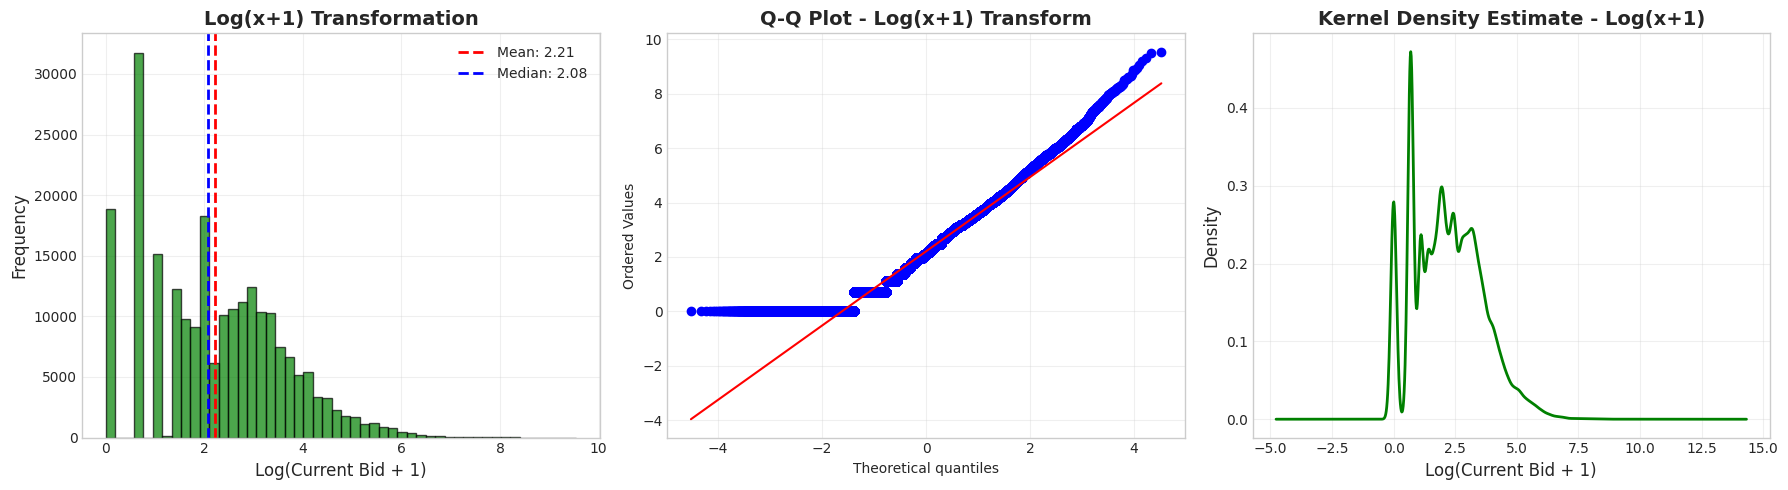

Log transformation plot saved


In [9]:
# Plot log transformed distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(current_bid_log, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Log(Current Bid + 1)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Log(x+1) Transformation', fontsize=14, fontweight='bold')
axes[0].axvline(current_bid_log.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {current_bid_log.mean():.2f}')
axes[0].axvline(current_bid_log.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {current_bid_log.median():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(current_bid_log, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot - Log(x+1) Transform', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# KDE Plot
current_bid_log.plot(kind='density', ax=axes[2], color='green', linewidth=2)
axes[2].set_xlabel('Log(Current Bid + 1)', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Kernel Density Estimate - Log(x+1)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_log_transform.png', dpi=150, bbox_inches='tight')
plt.show()

print("Log transformation plot saved")

## 5. Transformation 2: Square Root Transform

In [10]:
# Square root transformation
current_bid_sqrt = np.sqrt(current_bid.dropna())

print("="*60)
print("SQUARE ROOT TRANSFORMATION")
print("="*60)
print(f"\nDescriptive Statistics:")
print(current_bid_sqrt.describe())
print(f"\nSkewness: {current_bid_sqrt.skew():.4f}")
print(f"Kurtosis: {current_bid_sqrt.kurtosis():.4f}")

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(current_bid_sqrt.sample(min(5000, len(current_bid_sqrt))))
print(f"\nShapiro-Wilk Test (normality):")
print(f"  Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
print(f"  Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (at α=0.05)")

SQUARE ROOT TRANSFORMATION

Descriptive Statistics:
count    229125.000000
mean          3.650895
std           3.675500
min           0.000000
25%           1.414214
50%           2.645751
75%           4.795832
max         118.321596
Name: current_bid, dtype: float64

Skewness: 4.1870
Kurtosis: 45.3160

Shapiro-Wilk Test (normality):
  Statistic: 0.697279
  p-value: 0.000000
  Result: Not Normal (at α=0.05)


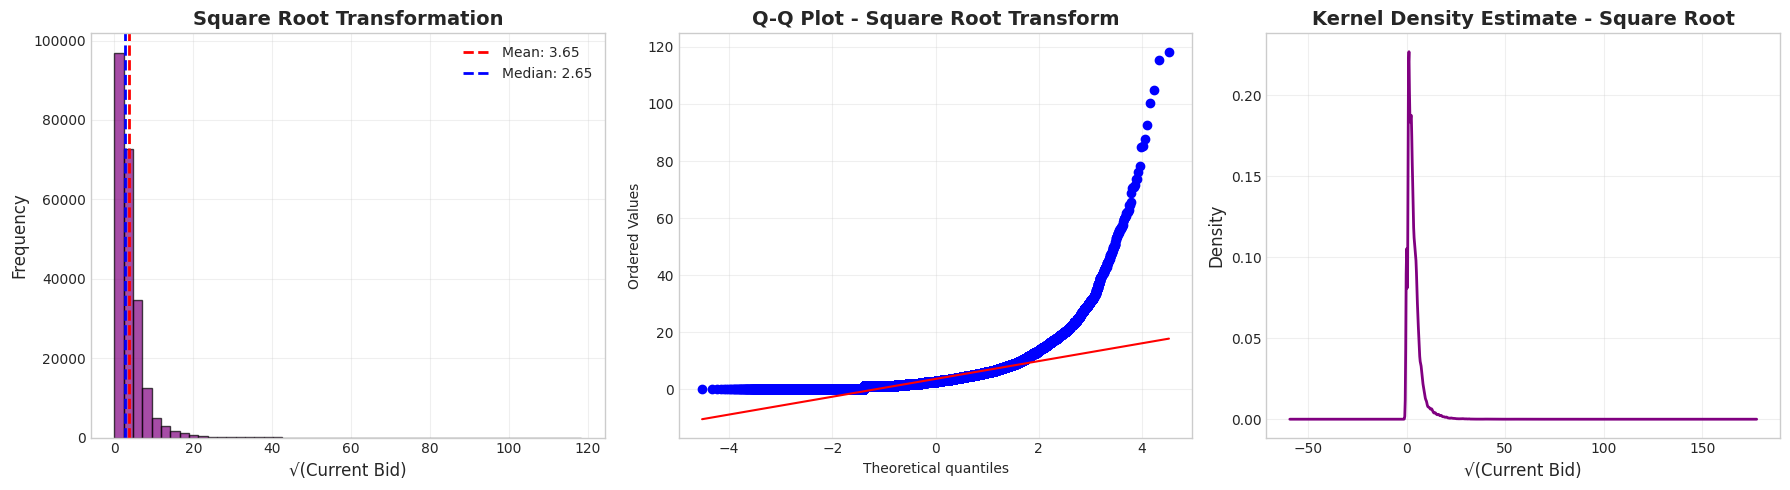

Square root transformation plot saved


In [11]:
# Plot square root transformed distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(current_bid_sqrt, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0].set_xlabel('√(Current Bid)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Square Root Transformation', fontsize=14, fontweight='bold')
axes[0].axvline(current_bid_sqrt.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {current_bid_sqrt.mean():.2f}')
axes[0].axvline(current_bid_sqrt.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {current_bid_sqrt.median():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(current_bid_sqrt, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot - Square Root Transform', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# KDE Plot
current_bid_sqrt.plot(kind='density', ax=axes[2], color='purple', linewidth=2)
axes[2].set_xlabel('√(Current Bid)', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Kernel Density Estimate - Square Root', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_sqrt_transform.png', dpi=150, bbox_inches='tight')
plt.show()

print("Square root transformation plot saved")

## 6. Transformation 3: Box-Cox Transform

In [12]:
# Box-Cox transformation (requires positive values)
current_bid_positive = current_bid[current_bid > 0].dropna()
current_bid_boxcox, lambda_param = stats.boxcox(current_bid_positive)

print("="*60)
print("BOX-COX TRANSFORMATION")
print("="*60)
print(f"\nOptimal lambda parameter: {lambda_param:.4f}")
print(f"\nDescriptive Statistics:")
print(pd.Series(current_bid_boxcox).describe())
print(f"\nSkewness: {pd.Series(current_bid_boxcox).skew():.4f}")
print(f"Kurtosis: {pd.Series(current_bid_boxcox).kurtosis():.4f}")

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(pd.Series(current_bid_boxcox).sample(min(5000, len(current_bid_boxcox))))
print(f"\nShapiro-Wilk Test (normality):")
print(f"  Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
print(f"  Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (at α=0.05)")

BOX-COX TRANSFORMATION

Optimal lambda parameter: -0.0737

Descriptive Statistics:
count    210303.000000
mean          1.960990
std           1.238934
min           0.000000
25%           1.055341
50%           2.028653
75%           2.865767
max           6.856220
dtype: float64

Skewness: 0.0225
Kurtosis: -0.6644

Shapiro-Wilk Test (normality):
  Statistic: 0.968720
  p-value: 0.000000
  Result: Not Normal (at α=0.05)


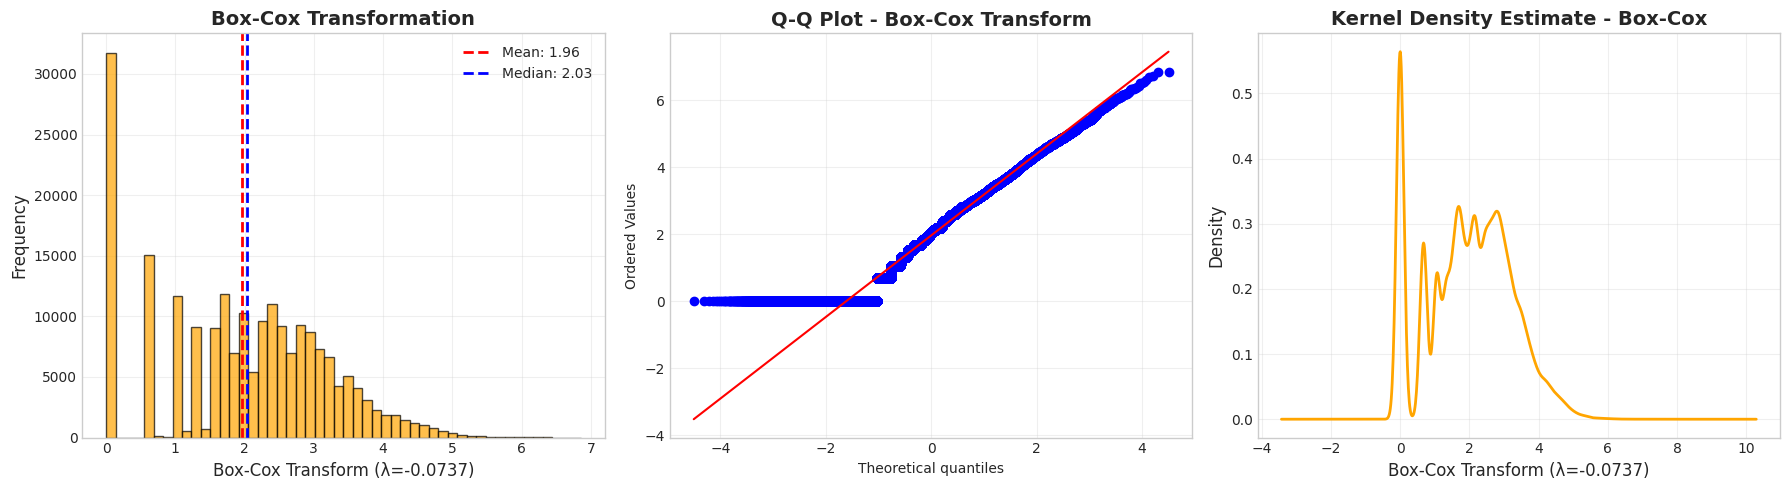

Box-Cox transformation plot saved


In [13]:
# Plot Box-Cox transformed distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(current_bid_boxcox, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0].set_xlabel(f'Box-Cox Transform (λ={lambda_param:.4f})', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Box-Cox Transformation', fontsize=14, fontweight='bold')
axes[0].axvline(current_bid_boxcox.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {current_bid_boxcox.mean():.2f}')
axes[0].axvline(np.median(current_bid_boxcox), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(current_bid_boxcox):.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(current_bid_boxcox, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot - Box-Cox Transform', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# KDE Plot
pd.Series(current_bid_boxcox).plot(kind='density', ax=axes[2], color='orange', linewidth=2)
axes[2].set_xlabel(f'Box-Cox Transform (λ={lambda_param:.4f})', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Kernel Density Estimate - Box-Cox', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_boxcox_transform.png', dpi=150, bbox_inches='tight')
plt.show()

print("Box-Cox transformation plot saved")

## 7. Transformation 4: Yeo-Johnson Transform

In [14]:
# Yeo-Johnson transformation (works with zero and negative values)
current_bid_yj, lambda_yj = stats.yeojohnson(current_bid.dropna())

print("="*60)
print("YEO-JOHNSON TRANSFORMATION")
print("="*60)
print(f"\nOptimal lambda parameter: {lambda_yj:.4f}")
print(f"\nDescriptive Statistics:")
print(pd.Series(current_bid_yj).describe())
print(f"\nSkewness: {pd.Series(current_bid_yj).skew():.4f}")
print(f"Kurtosis: {pd.Series(current_bid_yj).kurtosis():.4f}")

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(pd.Series(current_bid_yj).sample(min(5000, len(current_bid_yj))))
print(f"\nShapiro-Wilk Test (normality):")
print(f"  Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
print(f"  Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (at α=0.05)")

YEO-JOHNSON TRANSFORMATION

Optimal lambda parameter: -0.1189

Descriptive Statistics:
count    229125.000000
mean          1.855101
std           1.047966
min           0.000000
25%           1.029891
50%           1.842338
75%           2.646652
max           5.707754
dtype: float64

Skewness: 0.0348
Kurtosis: -0.6688

Shapiro-Wilk Test (normality):
  Statistic: 0.977223
  p-value: 0.000000
  Result: Not Normal (at α=0.05)


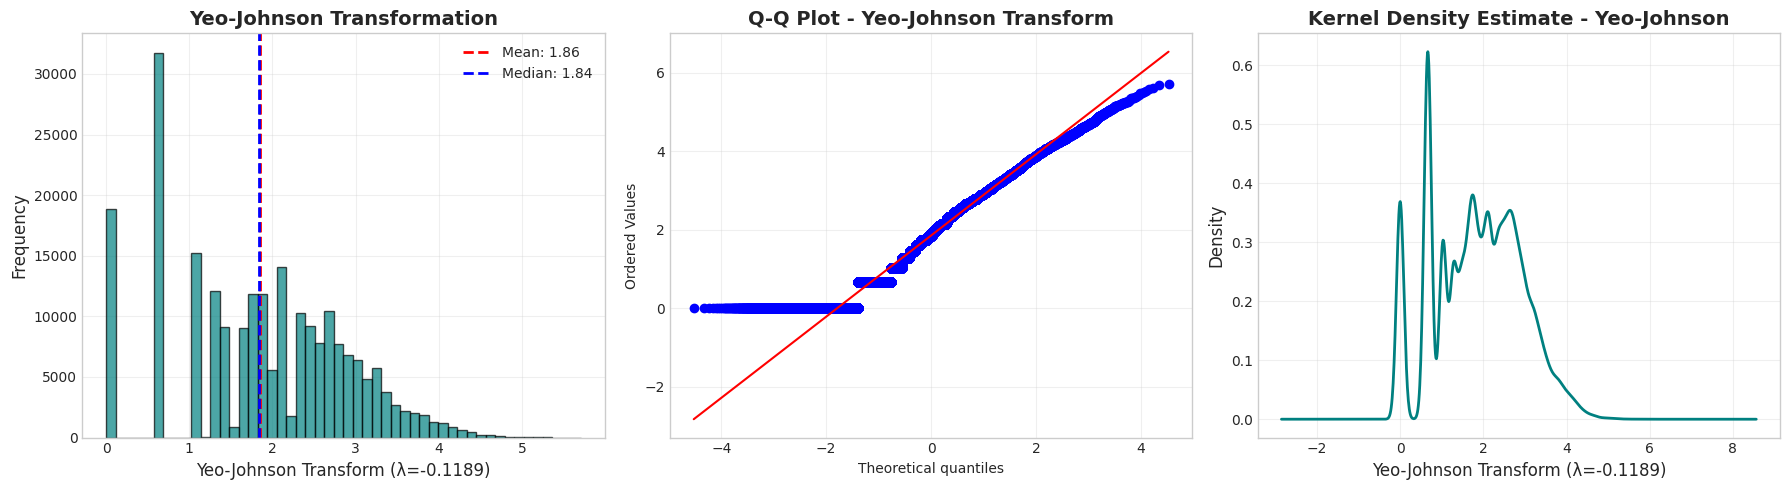

Yeo-Johnson transformation plot saved


In [15]:
# Plot Yeo-Johnson transformed distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(current_bid_yj, bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[0].set_xlabel(f'Yeo-Johnson Transform (λ={lambda_yj:.4f})', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Yeo-Johnson Transformation', fontsize=14, fontweight='bold')
axes[0].axvline(current_bid_yj.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {current_bid_yj.mean():.2f}')
axes[0].axvline(np.median(current_bid_yj), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(current_bid_yj):.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(current_bid_yj, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot - Yeo-Johnson Transform', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# KDE Plot
pd.Series(current_bid_yj).plot(kind='density', ax=axes[2], color='teal', linewidth=2)
axes[2].set_xlabel(f'Yeo-Johnson Transform (λ={lambda_yj:.4f})', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Kernel Density Estimate - Yeo-Johnson', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_yeojohnson_transform.png', dpi=150, bbox_inches='tight')
plt.show()

print("Yeo-Johnson transformation plot saved")

## 8. Transformation 5: Cube Root Transform

In [16]:
# Cube root transformation
current_bid_cbrt = np.cbrt(current_bid.dropna())

print("="*60)
print("CUBE ROOT TRANSFORMATION")
print("="*60)
print(f"\nDescriptive Statistics:")
print(current_bid_cbrt.describe())
print(f"\nSkewness: {current_bid_cbrt.skew():.4f}")
print(f"Kurtosis: {current_bid_cbrt.kurtosis():.4f}")

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(current_bid_cbrt.sample(min(5000, len(current_bid_cbrt))))
print(f"\nShapiro-Wilk Test (normality):")
print(f"  Statistic: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
print(f"  Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (at α=0.05)")

CUBE ROOT TRANSFORMATION

Descriptive Statistics:
count    229125.000000
mean          2.160170
std           1.391853
min           0.000000
25%           1.259921
50%           1.912931
75%           2.843867
max          24.101423
Name: current_bid, dtype: float64

Skewness: 1.5591
Kurtosis: 7.0739

Shapiro-Wilk Test (normality):
  Statistic: 0.884073
  p-value: 0.000000
  Result: Not Normal (at α=0.05)


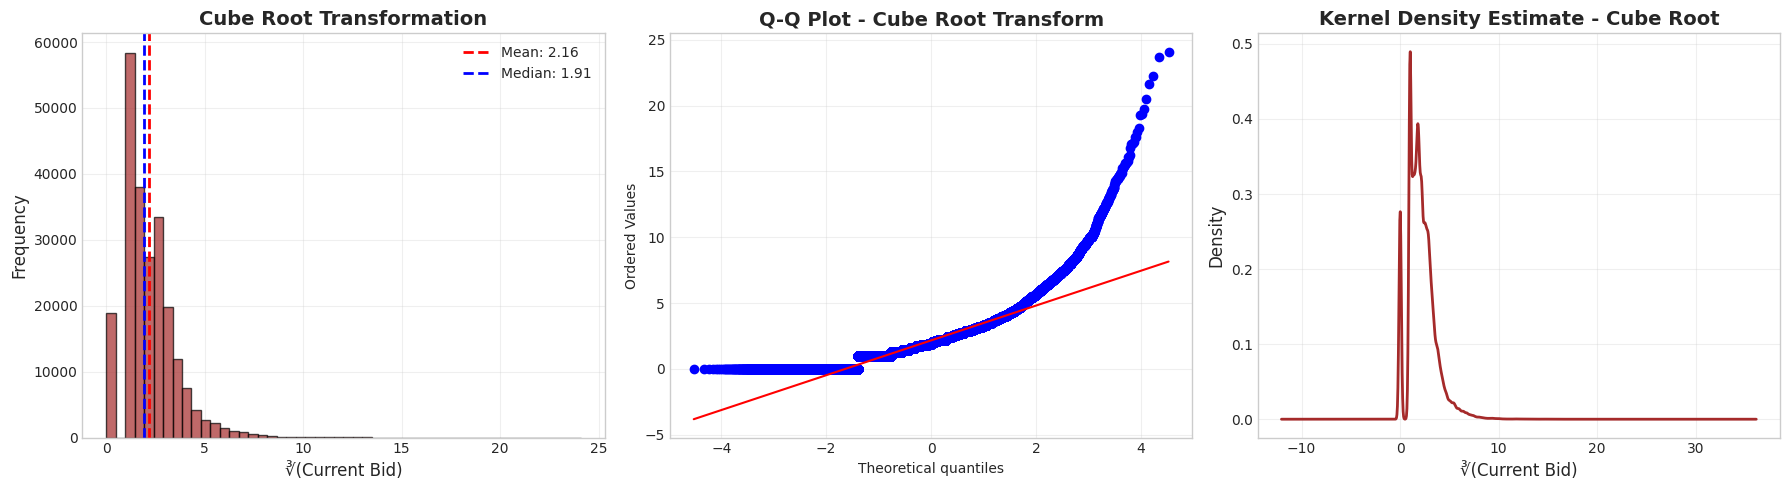

Cube root transformation plot saved


In [17]:
# Plot cube root transformed distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(current_bid_cbrt, bins=50, edgecolor='black', alpha=0.7, color='brown')
axes[0].set_xlabel('∛(Current Bid)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Cube Root Transformation', fontsize=14, fontweight='bold')
axes[0].axvline(current_bid_cbrt.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {current_bid_cbrt.mean():.2f}')
axes[0].axvline(current_bid_cbrt.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {current_bid_cbrt.median():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(current_bid_cbrt, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot - Cube Root Transform', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# KDE Plot
current_bid_cbrt.plot(kind='density', ax=axes[2], color='brown', linewidth=2)
axes[2].set_xlabel('∛(Current Bid)', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Kernel Density Estimate - Cube Root', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_cbrt_transform.png', dpi=150, bbox_inches='tight')
plt.show()

print("Cube root transformation plot saved")

## 9. Comparison of All Transformations

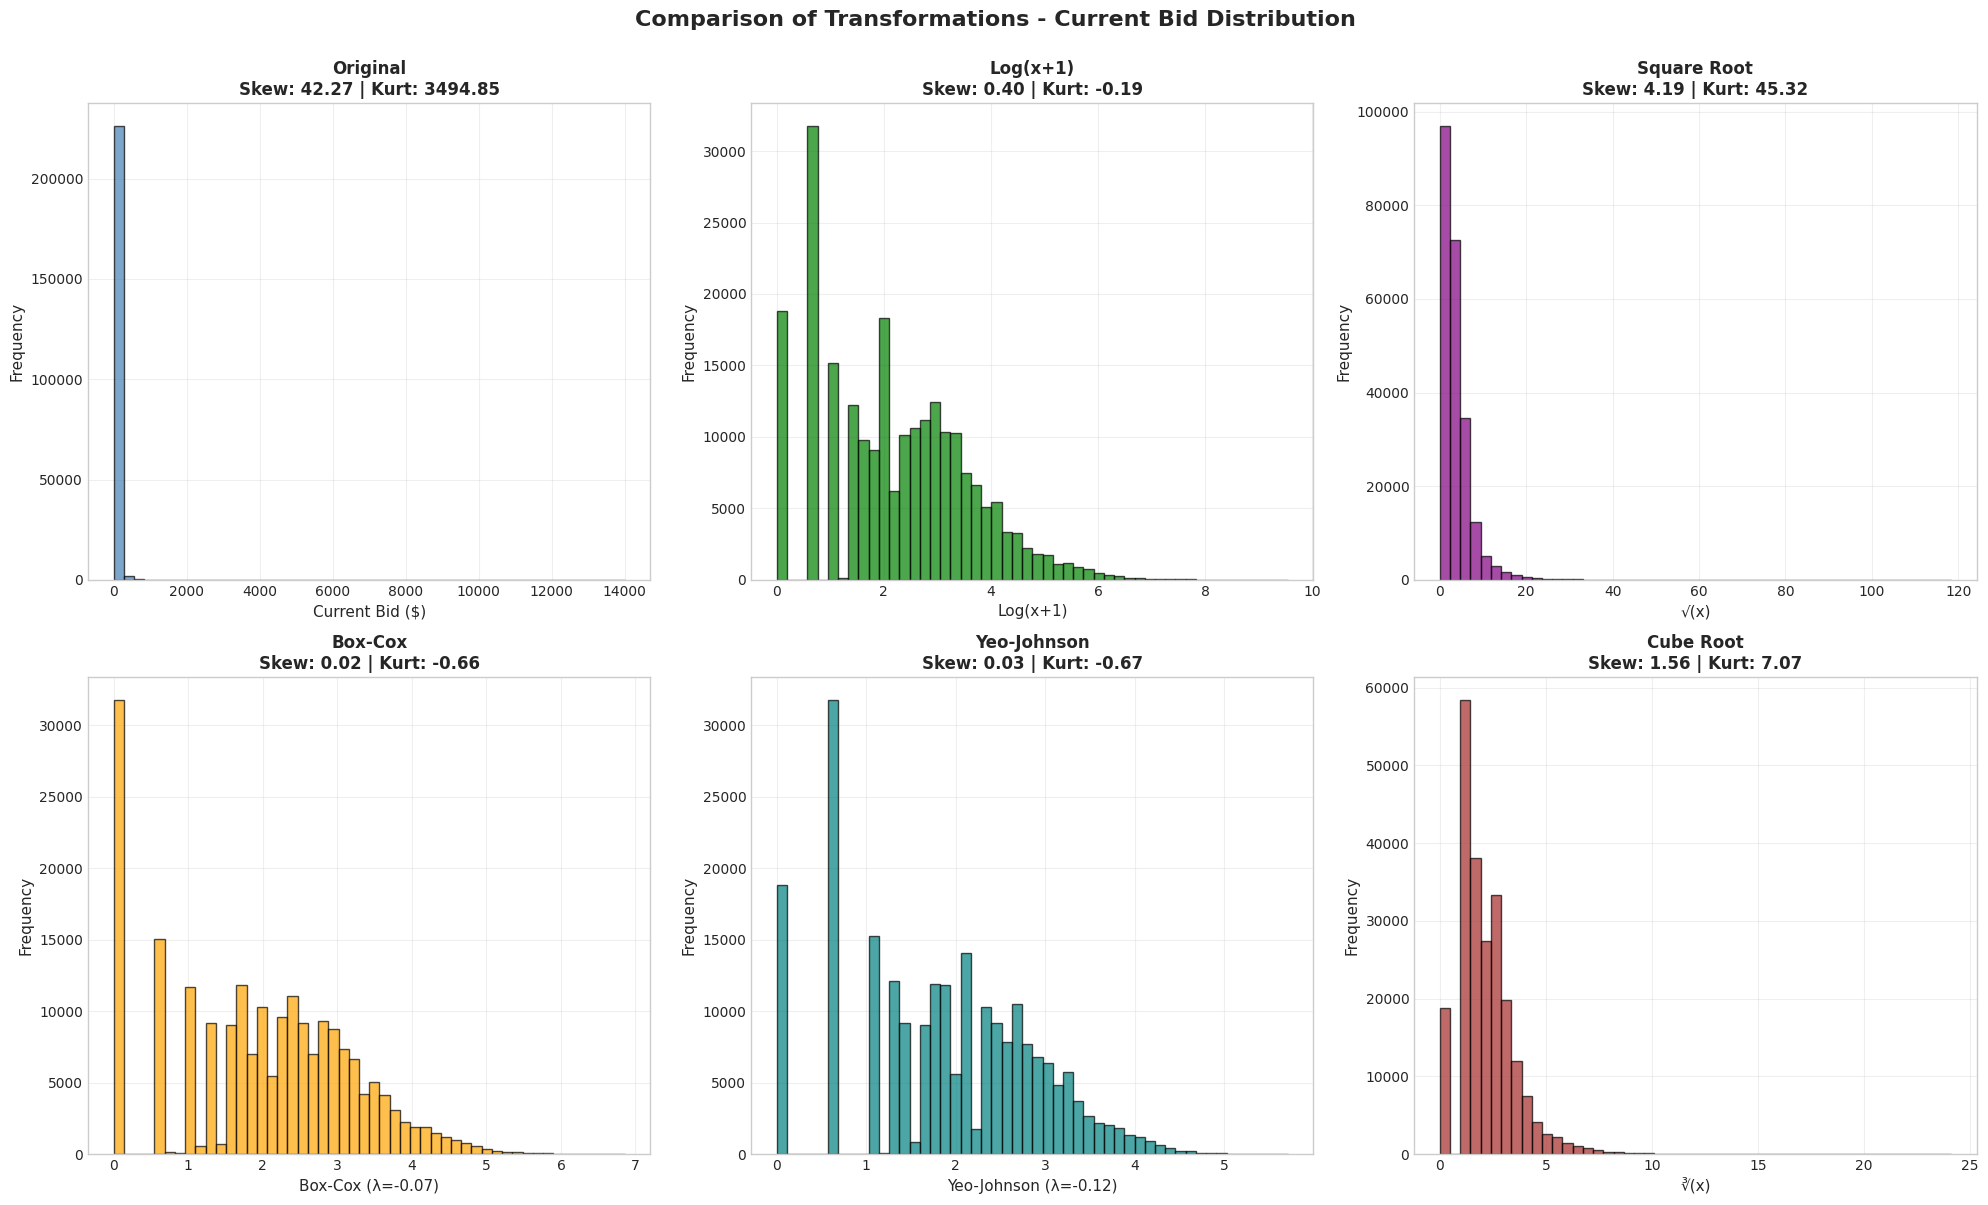

Comparison plot saved


In [18]:
# Create comparison plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Original
axes[0].hist(current_bid.dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Current Bid ($)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Original\nSkew: {current_bid.skew():.2f} | Kurt: {current_bid.kurtosis():.2f}', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Log
axes[1].hist(current_bid_log, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(x+1)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Log(x+1)\nSkew: {current_bid_log.skew():.2f} | Kurt: {current_bid_log.kurtosis():.2f}', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Square Root
axes[2].hist(current_bid_sqrt, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[2].set_xlabel('√(x)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title(f'Square Root\nSkew: {current_bid_sqrt.skew():.2f} | Kurt: {current_bid_sqrt.kurtosis():.2f}', 
                  fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Box-Cox
axes[3].hist(current_bid_boxcox, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[3].set_xlabel(f'Box-Cox (λ={lambda_param:.2f})', fontsize=11)
axes[3].set_ylabel('Frequency', fontsize=11)
axes[3].set_title(f'Box-Cox\nSkew: {pd.Series(current_bid_boxcox).skew():.2f} | Kurt: {pd.Series(current_bid_boxcox).kurtosis():.2f}', 
                  fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)

# Yeo-Johnson
axes[4].hist(current_bid_yj, bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[4].set_xlabel(f'Yeo-Johnson (λ={lambda_yj:.2f})', fontsize=11)
axes[4].set_ylabel('Frequency', fontsize=11)
axes[4].set_title(f'Yeo-Johnson\nSkew: {pd.Series(current_bid_yj).skew():.2f} | Kurt: {pd.Series(current_bid_yj).kurtosis():.2f}', 
                  fontsize=12, fontweight='bold')
axes[4].grid(True, alpha=0.3)

# Cube Root
axes[5].hist(current_bid_cbrt, bins=50, edgecolor='black', alpha=0.7, color='brown')
axes[5].set_xlabel('∛(x)', fontsize=11)
axes[5].set_ylabel('Frequency', fontsize=11)
axes[5].set_title(f'Cube Root\nSkew: {current_bid_cbrt.skew():.2f} | Kurt: {current_bid_cbrt.kurtosis():.2f}', 
                  fontsize=12, fontweight='bold')
axes[5].grid(True, alpha=0.3)

plt.suptitle('Comparison of Transformations - Current Bid Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('/workspaces/maxsold/EDA/current_bid_transformations_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison plot saved")

## 10. Summary Statistics Comparison

In [19]:
# Create summary comparison table
summary_data = {
    'Transformation': ['Original', 'Log(x+1)', 'Square Root', 'Box-Cox', 'Yeo-Johnson', 'Cube Root'],
    'Mean': [
        current_bid.mean(),
        current_bid_log.mean(),
        current_bid_sqrt.mean(),
        current_bid_boxcox.mean(),
        current_bid_yj.mean(),
        current_bid_cbrt.mean()
    ],
    'Median': [
        current_bid.median(),
        current_bid_log.median(),
        current_bid_sqrt.median(),
        np.median(current_bid_boxcox),
        np.median(current_bid_yj),
        current_bid_cbrt.median()
    ],
    'Std Dev': [
        current_bid.std(),
        current_bid_log.std(),
        current_bid_sqrt.std(),
        np.std(current_bid_boxcox),
        np.std(current_bid_yj),
        current_bid_cbrt.std()
    ],
    'Skewness': [
        current_bid.skew(),
        current_bid_log.skew(),
        current_bid_sqrt.skew(),
        pd.Series(current_bid_boxcox).skew(),
        pd.Series(current_bid_yj).skew(),
        current_bid_cbrt.skew()
    ],
    'Kurtosis': [
        current_bid.kurtosis(),
        current_bid_log.kurtosis(),
        current_bid_sqrt.kurtosis(),
        pd.Series(current_bid_boxcox).kurtosis(),
        pd.Series(current_bid_yj).kurtosis(),
        current_bid_cbrt.kurtosis()
    ]
}

summary_df = pd.DataFrame(summary_data)

print("="*80)
print("TRANSFORMATION COMPARISON SUMMARY")
print("="*80)
print("\nNote: For normality, Skewness should be close to 0, Kurtosis close to 0")
print("(Excess kurtosis; normal distribution has kurtosis = 0)\n")
print(summary_df.to_string(index=False))

# Find best transformation (closest to normal)
summary_df['Normality Score'] = np.abs(summary_df['Skewness']) + np.abs(summary_df['Kurtosis'])
best_transform = summary_df.loc[summary_df['Normality Score'].idxmin(), 'Transformation']

print(f"\n{'='*80}")
print(f"BEST TRANSFORMATION (lowest skew + kurtosis): {best_transform}")
print(f"{'='*80}")

# Save summary
summary_df.to_csv('/workspaces/maxsold/EDA/current_bid_transformations_summary.csv', index=False)
print("\nSummary table saved to: /workspaces/maxsold/EDA/current_bid_transformations_summary.csv")

TRANSFORMATION COMPARISON SUMMARY

Note: For normality, Skewness should be close to 0, Kurtosis close to 0
(Excess kurtosis; normal distribution has kurtosis = 0)

Transformation      Mean   Median    Std Dev  Skewness    Kurtosis
      Original 26.838278 7.000000 111.316193 42.274857 3494.849742
      Log(x+1)  2.207200 2.079442   1.384613  0.402262   -0.185241
   Square Root  3.650895 2.645751   3.675500  4.186988   45.315972
       Box-Cox  1.960990 2.028653   1.238931  0.022470   -0.664408
   Yeo-Johnson  1.855101 1.842338   1.047963  0.034820   -0.668811
     Cube Root  2.160170 1.912931   1.391853  1.559097    7.073856

BEST TRANSFORMATION (lowest skew + kurtosis): Log(x+1)

Summary table saved to: /workspaces/maxsold/EDA/current_bid_transformations_summary.csv


## 11. Recommendations

Based on the analysis above:

1. **Original Distribution**: Highly right-skewed with extreme outliers
2. **Log(x+1)**: Good for reducing right skew, handles zeros well
3. **Square Root**: Moderate transformation, less aggressive than log
4. **Box-Cox**: Optimal power transformation (requires positive values)
5. **Yeo-Johnson**: Similar to Box-Cox but handles zeros and negatives
6. **Cube Root**: Mild transformation, preserves sign for negative values

**For modeling:**
- If using algorithms sensitive to scale (e.g., linear regression, neural networks): Use Box-Cox or Yeo-Johnson
- If using tree-based models (e.g., XGBoost, Random Forest): Transformation less critical
- For interpretability: Log(x+1) is easiest to explain and reverse